In [1]:
# import relevant dataset and training utilities from Github
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
%pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 98.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# import the necessary packages and define device
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
### fetch images that contain masks of people

# loop thur the images and annotations_instace folders to fetch filenames
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

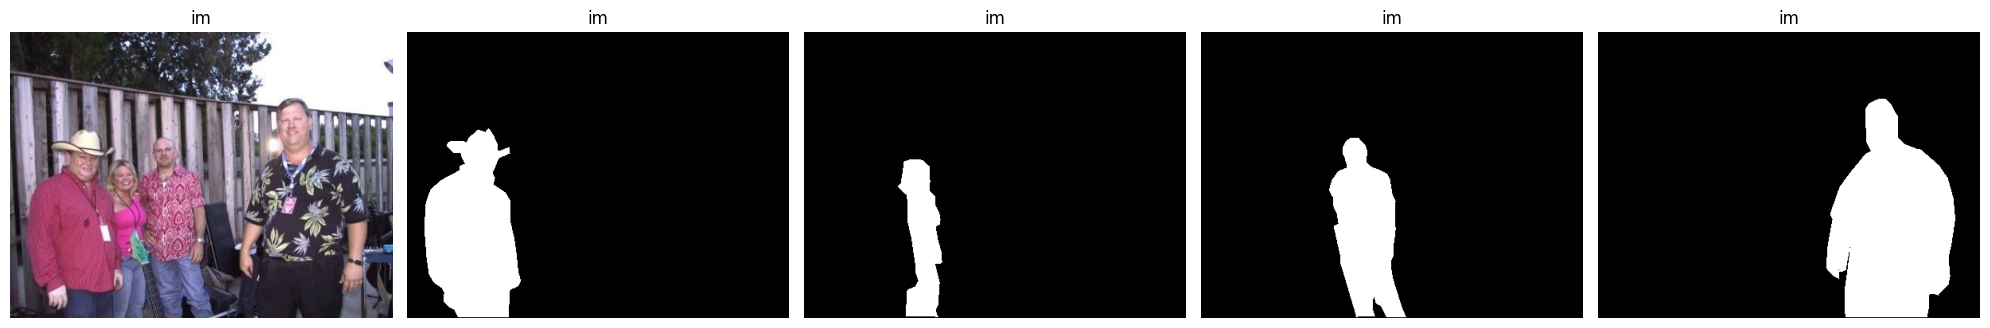

In [6]:
# inspect the original image and the represention of masks of instance of people
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r, g, b = an
# 4 stands for person
nzs = np.nonzero(r==4)
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix, _id in enumerate(instances):
  masks[ix] = g == _id
subplots([im, *masks], sz=20)

# In this particular dataset, the ground-truth instance
# annotations are provided in such a way that the Red
# channel in RGB corresponds to the class of object,
# while the Green channel corresponds to the instance
# number (if there are multiple objects of the same
# class in the image, as in our example here).
# Furthermore, the Person class is encoded with a value
# of 4.

In [7]:
# loop thru the annotations and store the files that contain at least on person
annots  = []
for ann in Tqdm(all_annots[:5000]):
  _ann = read(ann, 1).transpose(2,0,1)
  r, g, b = _ann
  if 4 not in np.unique(r): continue
  annots.append(ann)

100%|██████████| 5000/5000 [00:46<00:00, 107.87it/s]


In [8]:
# split the files into training and validation files
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [9]:
# define the transformation method
def get_transforms(train):
  image_transforms = []
  image_transforms.append(T.PILToTensor())
  if train:
    image_transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(image_transforms)

In [10]:
# create the dataset class
class MasksDataset(Dataset):
  # define the init method which takes the image names(items),
  # transformation method and the number of files to consider as input
  def __init__(self, items, transforms, N):
    self.items = items
    self.transforms = transforms
    self.N = N

  # define the get_mask method that will fetch the number of masks that's
  # equivalent to the instaces present in the image
  def get_mask(self, path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    nzs = np.nonzero(r==4)
    instances = np.unique(g[nzs])
    masks = np.zeros((len(instances), *r.shape))
    for ix,_id in enumerate(instances):
        masks[ix] = g==_id
    return masks

  # fetch the image and the correspindig target values to be returned
  # each person(instance) is treated as a different object class;
  # that is, each instance is a different class
  def __getitem__(self, ix):
    _id = self.items[ix]
    img_path = f'images/training/{_id}.jpg'
    mask_path = f'annotations_instance/training/{_id}.png'
    masks = self.get_mask(mask_path)
    obj_ids = np.arange(1, len(masks)+1)
    img = Image.open(img_path).convert("RGB")
    num_objs = len(obj_ids)
    # apart from the masks themselves, Mask R-CNN also needs the bounding-box info
    boxes = []
    for i in range(num_objs):
        obj_pixels = np.where(masks[i])
        xmin = np.min(obj_pixels[1])
        xmax = np.max(obj_pixels[1])
        ymin = np.min(obj_pixels[0])
        ymax = np.max(obj_pixels[0])
        # adjust for scenarios where there are dubious ground truths
        if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
            xmax = xmin+10
            ymax = ymin+10
        boxes.append([xmin, ymin, xmax, ymax])
    # convert all the target values into tensor objects
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([ix])
    # store the target values in a dictionary
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    # specify the transformation method and return the image after scaling it
    if self.transforms is not None:
        img, target = self.transforms(img, target)
    if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
      img = img/255.
    return img, target
  def __len__(self):
    return self.N
  # define a function that will choose a random image
  def choose(self):
    return self[randint(len(self))]

══════════════════════════════════════════════════════════════════
tensor[3, 256, 256] n=196608 (0.8Mb) x∈[0., 1.000] μ=0.497 σ=0.211
══════════════════════════════════════════════════════════════════
dict of 6 items
tensor[3, 4] n=12 x∈[3.000, 166.000] μ=105.583 σ=67.334
tensor[3] i64 x∈[1, 1] μ=1.000 σ=0. [1, 1, 1]
tensor[3, 256, 256] u8 n=196608 (0.2Mb) x∈[0, 1] μ=0.002 σ=0.048
tensor[1] i64 [0]
tensor[3] x∈[200.000, 416.000] μ=282.667 σ=116.573 [416.000, 232.000, 200.000]
... ... 1 more item(s)
══════════════════════════════════════════════════════════════════


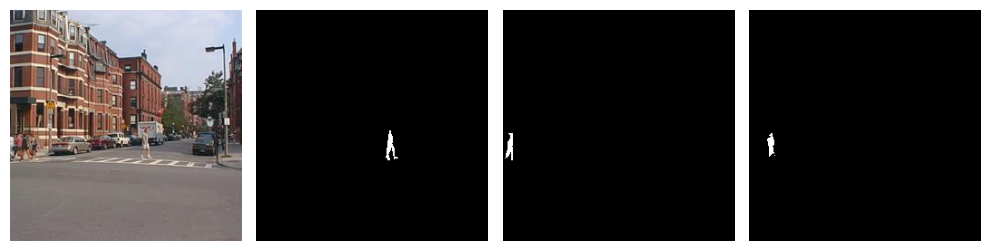

In [11]:
#inspect an input-output combination
x = MasksDataset(trn_items, get_transforms(train=True), N=100)
im, targ = x[0]
inspect(im, targ)
subplots([im, *targ['masks']], sz=10)

In [ ]:
# Note that, in the __getitem__ method, we have as many masks and
# bounding boxes in an image as there are objects (instances) present
# within the image. Furthermore, because we only have two classes (the
# Background class and the Person class), we specify the Person class as 1.
# By the end of this step, we have quite a lot of information in the output
# dictionary, that is, the object classes, bounding boxes, masks, the area
# of the masks, and if a mask corresponds to a crowd. All of this
# information is available in the target dictionary. For the training
# function that we are going to use, it is important for the data to be
# standardized in the format that the torchvision.models.detection.maskrcnn_resnet50_fpn class requires it to be in.

In [12]:
# define the instance segmentation model
# We are going to use a pre-trained model
# with only the heads reinitialized to predict two classes (background and
# person). First, we need to initialize a pre-trained model and replace the
# box_predictor and mask_predictor heads so that they can be learned from scratch
def get_model_instance_segmentation(num_classes):
  # load an instance segmentation model pre-trained of COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  #replace the pretrained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
  return model

In [13]:
model = get_model_instance_segmentation(2).to(device)
# get the details of the defined model
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 131MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [14]:
# fetch the dataset and dataloaders that correspond to the train and validation images
dataset = MasksDataset(trn_items, get_transforms(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transforms(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers = 0,
    collate_fn = utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers = 0,
    collate_fn=utils.collate_fn
)

In [19]:
# define the model, parameters, and optimization criterion
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer  = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate schedular
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# train model
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  trn_history.append(res)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  res = evaluate(model, data_loader_test, device=device)

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/487]  eta: 0:05:37  lr: 0.000015  loss: 2.8643 (2.8643)  loss_classifier: 0.6981 (0.6981)  loss_box_reg: 0.4257 (0.4257)  loss_mask: 1.6267 (1.6267)  loss_objectness: 0.0440 (0.0440)  loss_rpn_box_reg: 0.0698 (0.0698)  time: 0.6931  data: 0.0893  max mem: 3487
Epoch: [0]  [ 10/487]  eta: 0:05:02  lr: 0.000118  loss: 2.6422 (2.5831)  loss_classifier: 0.6981 (0.6903)  loss_box_reg: 0.3804 (0.3723)  loss_mask: 1.4103 (1.4198)  loss_objectness: 0.0418 (0.0452)  loss_rpn_box_reg: 0.0278 (0.0554)  time: 0.6339  data: 0.0483  max mem: 4282


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 20/487]  eta: 0:05:00  lr: 0.000221  loss: 1.8002 (2.0256)  loss_classifier: 0.4310 (0.5167)  loss_box_reg: 0.3596 (0.3660)  loss_mask: 0.7852 (1.0529)  loss_objectness: 0.0378 (0.0418)  loss_rpn_box_reg: 0.0193 (0.0481)  time: 0.6409  data: 0.0571  max mem: 4282
Epoch: [0]  [ 30/487]  eta: 0:05:03  lr: 0.000324  loss: 1.2675 (1.7746)  loss_classifier: 0.2917 (0.4348)  loss_box_reg: 0.3133 (0.3721)  loss_mask: 0.5367 (0.8805)  loss_objectness: 0.0311 (0.0426)  loss_rpn_box_reg: 0.0152 (0.0447)  time: 0.6811  data: 0.0946  max mem: 4282
Epoch: [0]  [ 40/487]  eta: 0:04:53  lr: 0.000426  loss: 1.0325 (1.6004)  loss_classifier: 0.1951 (0.3864)  loss_box_reg: 0.3133 (0.3715)  loss_mask: 0.4193 (0.7607)  loss_objectness: 0.0297 (0.0438)  loss_rpn_box_reg: 0.0101 (0.0380)  time: 0.6711  data: 0.0933  max mem: 4282
Epoch: [0]  [ 50/487]  eta: 0:04:53  lr: 0.000529  loss: 1.0325 (1.4903)  loss_classifier: 0.2108 (0.3532)  loss_box_reg: 0.4027 (0.3748)  loss_mask: 0.3854 (0.6854) 

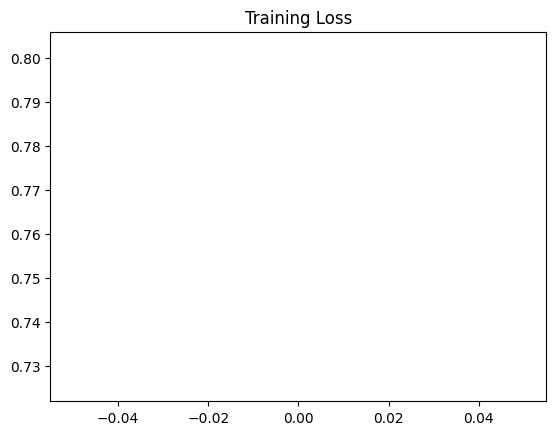

In [25]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

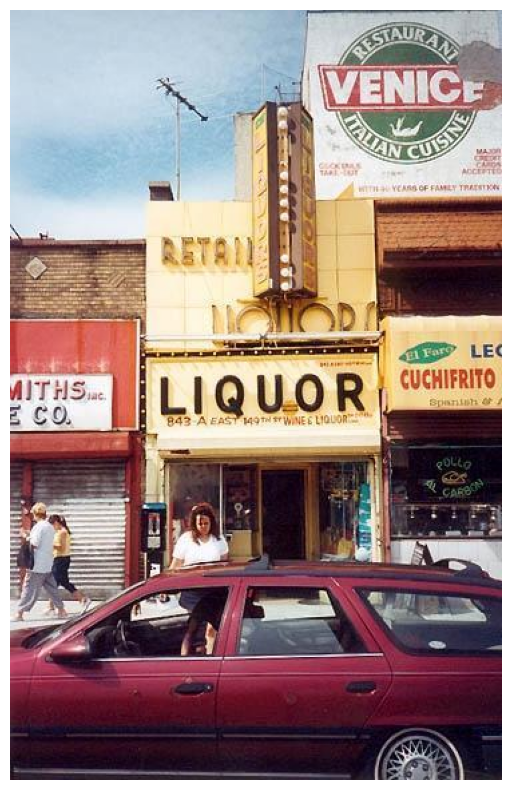

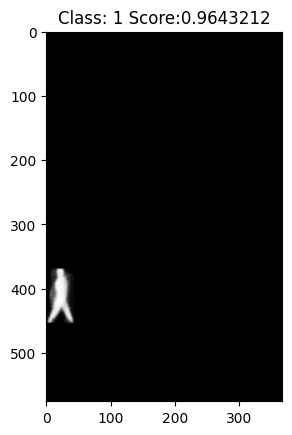

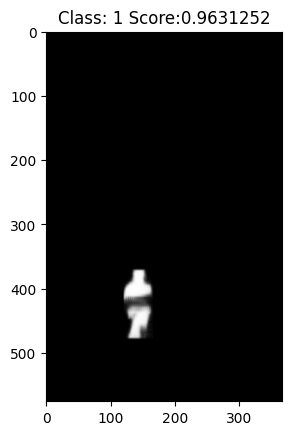

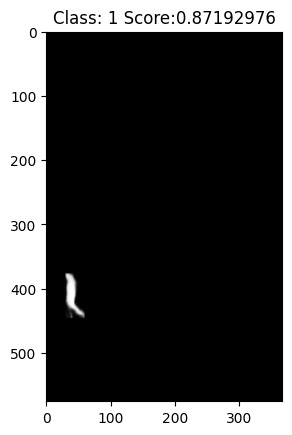

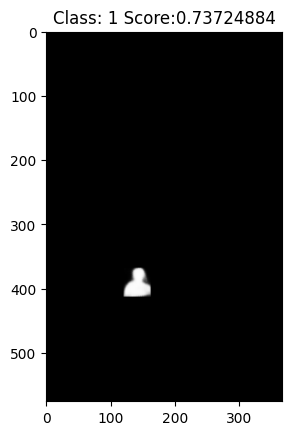

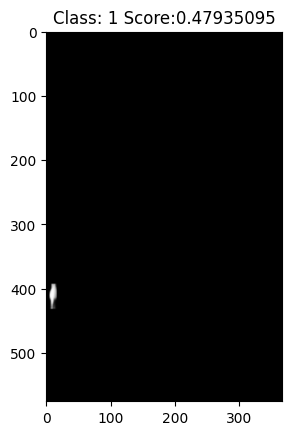

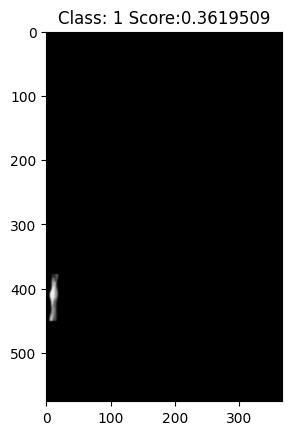

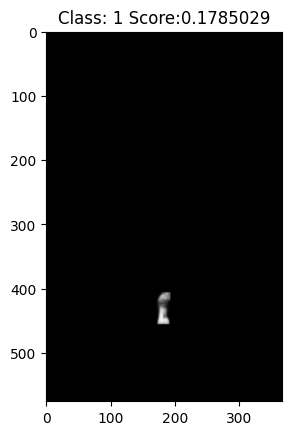

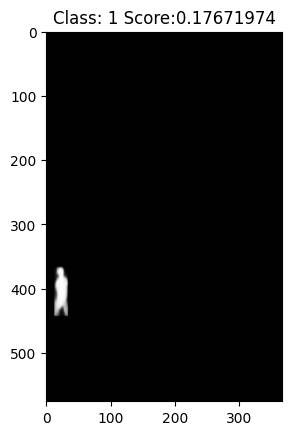

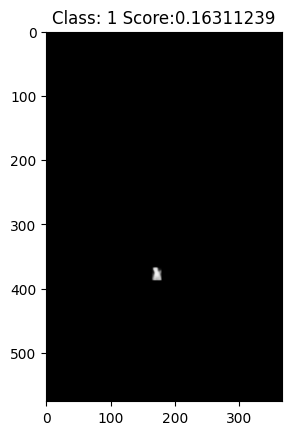

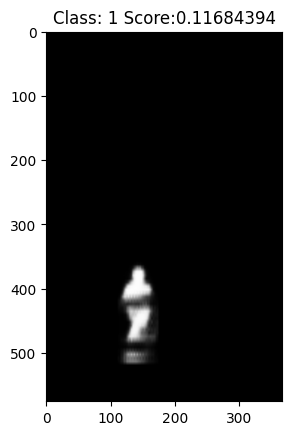

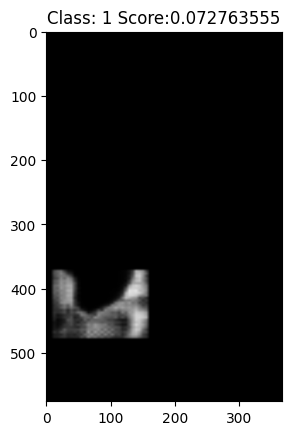

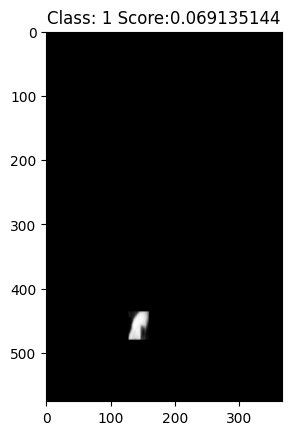

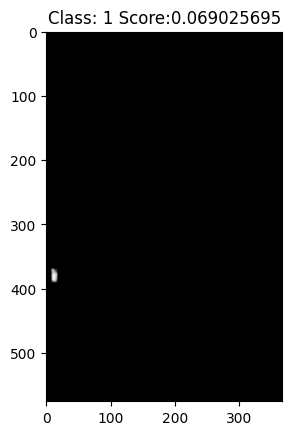

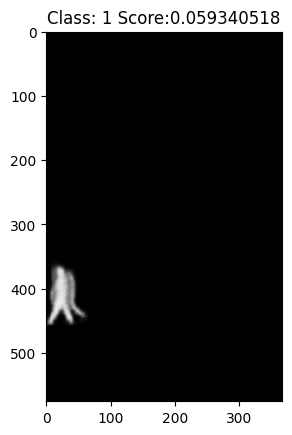

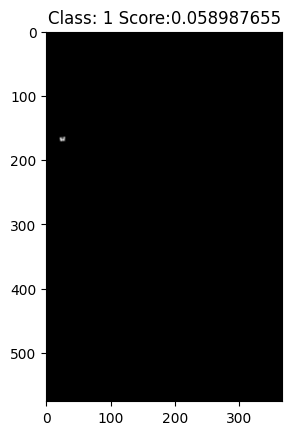

In [23]:
# predict on a test image
model.eval()
im = dataset_test[10][0]
show(im)
with torch.no_grad():
  prediction = model([im.to(device)])
  for i in range(len(prediction[0]['masks'])):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).cpu().numpy()))
    plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
    plt.show()